# 3K2F G-ADSA Analysis: Low Pressure (0-5.5 MPa)

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of polypropylene glycol (PPG), a difunctional polyol from Sigma-Aldrich with molecular weight ~2700 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from June 26-30, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 60 C.

**Because the ADSA video stopped recording before the end of the experiment, we interpolated the specific volumes at the pressures missing ADSA data using a quadratic fit.**

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [15]:
%load_ext autoreload
%autoreload 2

# imports 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# imports custom libraries
import sys
sys.path.append('../src/')
import dataproc
import errprop
import plot
from timedate import TimeDate


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../input/adsa/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190626_0630_3k2f_60c_adsa_volume.csv']
# list of data files with interfacial tension data--leave blank if not complete
adsa_if_tension_file_list = ['20190626_0630_3k2f_60c_adsa_if_tension.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../input/gravimetry/3k2f_60c-TRD-062619-1737.csv'
# start of experiment (time stamp on TRD file above^)
date_ref = '6/26/2019'
time_ref = '17:37:00'
# file path to save results
save_folder = '../output/'
save_data_name = '3k2f_60c_lop.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 6/26 17:38:26; adsa video 6/26 17:46
adsa_t0_list = [60*7 + 34]
# number of measurements to average for surface tension and volume readings
n_adsa = 10

# polyol code name
polyol = '3k2f_lop'
# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.691
# volume of drop in atmospheric pressure, from 20190626_3k2f_1bar_snapshot.mdb [uL]
v_drop_atm = 3.956
# uncertainty in drop volume at atmospheric conditions [uL]
s_v_drop_atm = 0.02
# density of polyol sample at atmospheric pressure and 25 C (SDS) and extrapolated using P-1000 Dow data [g/mL]
rho_samp_atm = 0.977
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa], p=5400 has inaccurate ADSA, last 0 kpa lacks
# mp2 measurement, so these are excluded
p_set_arr = np.array([0, 50, 150, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3950, 4450,
                       4950, 5350, 4600, 3850, 3100, 2400, 1600, 900, 700, 500, 300, 240, 190, 135, 90, 37]) 
i_missing_adsa = np.where(p_set_arr==2400)[0][0] # first index where drop volume is missing
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# number of measurements of pressure within equilibrium (300 s, every 30 s)
n_p_eq = 10

# CONSTANTS
# Set-point temperature [C]
T = 60
# atmospheric pressure [kPa]
P_ATM = 101.3
# density of air at sea level acc. to https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html [g/mL]
RHO_AIR = 1.225E-3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + RHO_AIR*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [16]:
# load (and validate) raw data
time_date_ref = TimeDate(date_str=date_ref, time_str=time_ref)

# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, \
                                                                                      adsa_t0_list, grav_file_path, p_set_arr,
                                                                          time_date_ref=time_date_ref)
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,specific volume [mL/g],specific volume (fit) [mL/g],specific volume error [mL/g],specific volume error (stat) [mL/g],specific volume error (sys) [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (sqrt) std [cm^2/s],diffusivity (exp) [cm^2/s],diffusivity (exp) std [cm^2/s],diffusion time constant [s]
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 0 kPa.
Rejected 1 outliers.
Drop volume = 3.982500 uL.
Pressure = 50 kPa.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 3.976000 uL.
Pressure = 150 kPa.
Drop volume = 3.964900 uL.
Pressure = 500 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.016300 uL.
Pressure = 1000 kPa.
Rejected 1 outliers.
Drop volume = 4.042500 uL.
Pressure = 1500 kPa.
Rejected 1 outliers.
Drop volume = 4.090700 uL.
Pressure = 2000 kPa.
Rejected 1 outliers.
Drop volume = 4.138100 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.179800 uL.
Pressure = 3000 kPa.
Rejected 1 outliers.
Drop volume = 4.233200 uL.
Pressure = 3500 kPa.
Rejected 1 outliers.
Drop volume = 4.269200 uL.
Pressure = 3950 kPa.
Rejected 1 outliers.
Drop volume = 4.325300 uL.
Pressure = 4450 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.371900 uL.
Pressure = 4950 kPa.
Rejected 1 outliers.
Drop volume = 4.411600 uL.
Pressure = 5350 kPa.
Rejected 1 outliers.
Drop volume = 4.476700 uL.
Pressure = 4600 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.385300 uL.
Pressure = 3850 kPa.
Rejected 1 outliers.
Drop volume = 4.314800 uL.
Pressure = 3100 kPa.
Rejected 1 outliers.
Drop volume = 4.223900 uL.
Pressure = 2400 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 1600 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
../src\plot.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 900 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 700 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 500 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 300 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
../src\plot.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=figsize)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 240 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 190 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 135 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 90 kPa.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.
Pressure = 37 kPa.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.223900 uL.


../src\plot.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=figsize)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
../src\plot.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subp

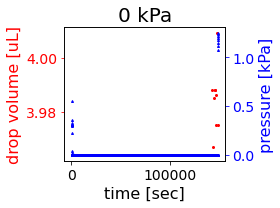

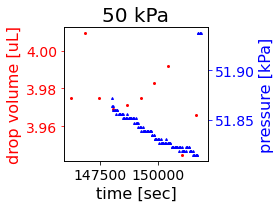

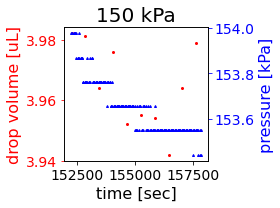

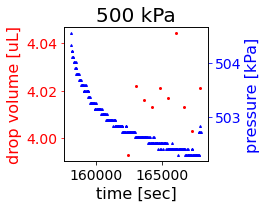

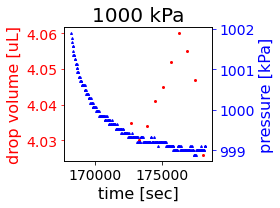

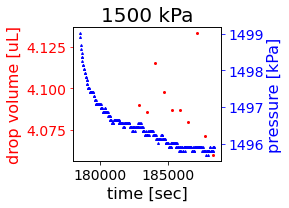

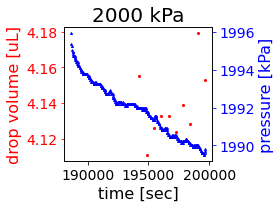

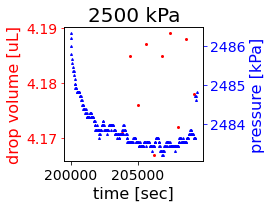

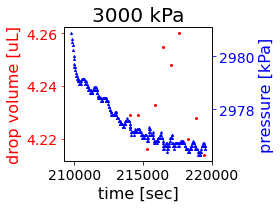

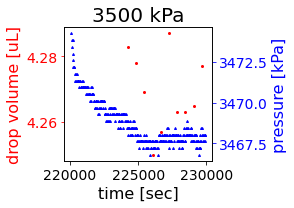

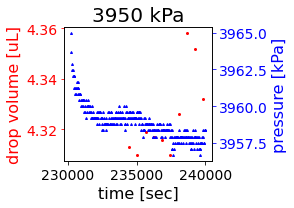

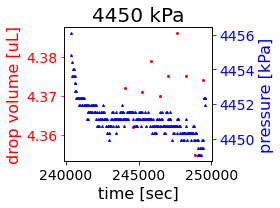

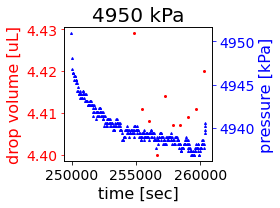

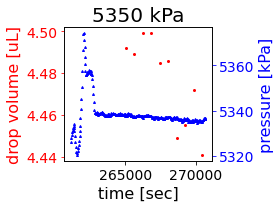

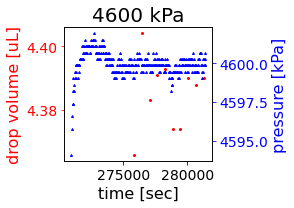

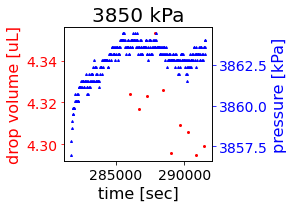

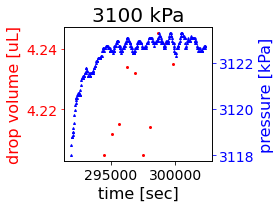

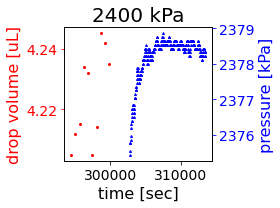

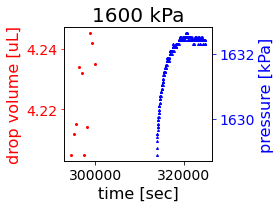

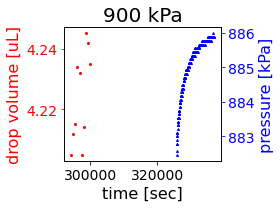

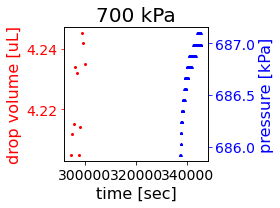

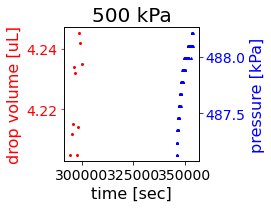

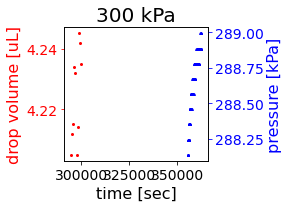

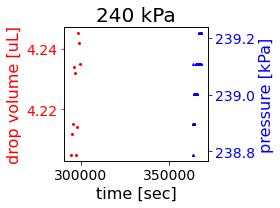

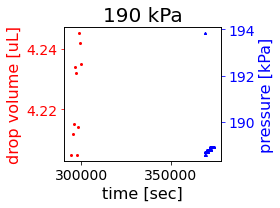

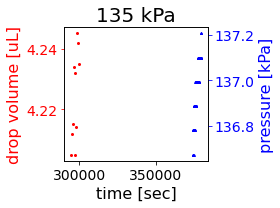

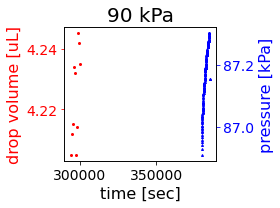

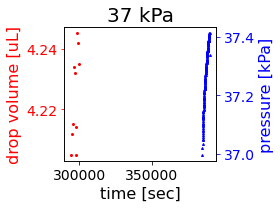

In [17]:
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization

# initalize marker for pressure bounds
i_p1 = 0
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
    # Shift initial index if there are more points to the final index than required for equilibrium pressure measurement
    i_p0_shifted = max(i_p0, i_p1-n_p_eq)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[i_p0_shifted:i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = np.std(p_eq)
    # store results in data frame; use times to determine indices of ADSA to use
    i_adsa = dataproc.get_inds_adsa(t_adsa, t_grav, i_p0, i_p1, n_adsa)
    
    # plot drop volume measurements alongside pressure
    plot.plot_two_axes(t_adsa[i_adsa], v_drop[i_adsa], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['drop vol', 'p'], xlabel='time [sec]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='%d kPa' % p_set)
    
    # store results in data frame
    df = dataproc.store_grav_adsa(df, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_adsa)

**As was the case in the 1k2f 30 C experiment, the pressure had a strange shape at the beginning of the rise to 5500 kPa, this time starting low, jumping up, and then slowly decreasing. This shape is a result of the limitation of the pressure that can be provided by the CO2 tank (a little less than 5500 kPa).**
Besides this anomalous example, the pressure remained within 10 kPa of the average value (which was not necessarily the set value).

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must compute the mass and volume of the polymer under vacuum.

In [18]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# (extract value at 0 pressure) [g]
br_eq_0 = br_eq[0]
# or it could be 7.97264 - (-0.00895) from end of experiment
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere with linear interpolation--index 2 corresponds to ~100 kPa [g]
w_gas_atm = br_gas[2] + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_drop_0 = v_drop[0] # drop volume under vacuum [uL]
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 0.691991 g vs. mass of polymer at atmospheric pressure = 0.691000 g.
Dry polymer mass estimated using tare measurement = 0.7013299349999995 g.
Volume of dry polymer in crucible is approximately ~ 0.698864 mL (using atmospheric density).


### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [19]:
# set parameters for error propagation
n = len(p_set_arr)
w_poly_arr = w_poly*np.ones([n])
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_atm*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop_atm*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)
s_zero = df['zero std [g]'].to_numpy(dtype=float)
s_w_gas_ref = 0.00001*np.ones([n]) # uncertainty in weight measured by Rubotherm = resolution of Rubotherm [g]

### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

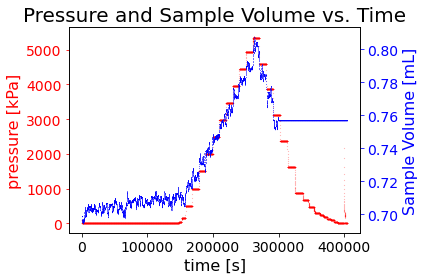

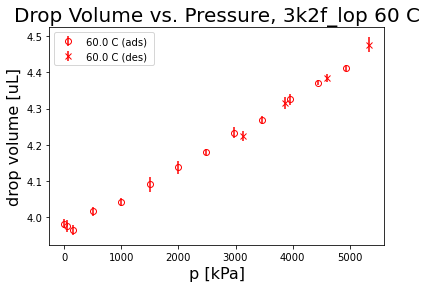

In [20]:
# Drop volume [uL]
v_drop_eq = np.nan*np.ones([len(df)])
s_v_drop_eq = np.nan*np.ones([len(df)])
v_drop_eq[:i_missing_adsa] = df['drop volume [uL]'].to_numpy(dtype=float)[:i_missing_adsa]
s_v_drop_eq[:i_missing_adsa] = df['drop volume std [uL]'].to_numpy(dtype=float)[:i_missing_adsa]
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp
# error in volume of sample [mL]
s_v_samp = np.nan*np.ones([len(df)])
s_v_samp = errprop.error_v_samp(v_samp, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, 
                                s_v_drop_eq, v_drop_ref, s_v_drop_ref)
df['sample volume std [mL]'] = s_v_samp # ??? do i need to append dummy entries where there are no ADSA data?

# compute live change in volume
v_samp_adsa = v_drop / v_drop_atm * v_samp_atm
v_samp_grav = np.interp(t_grav, t_adsa, v_samp_adsa)
inds_pos = t_grav > 0
plot.plot_two_axes(t_grav[inds_pos], p_arr[inds_pos], v_samp_grav[inds_pos], labels=[r'$p$', r'$V_{samp}$'], xlabel='time [s]', 
                   ms=0.1, ylabels=['pressure [kPa]', 'Sample Volume [mL]'], title='Pressure and Sample Volume vs. Time')

# extract data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (red color for warm temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_v_drop_eq, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))

if save_plots:
    plt.savefig(save_folder + 'drop_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

Because the ADSA software ran out of frames to record around 5am June 30th (during the p = 3100 kPa pressure step), there are no measurements of drop volume for pressures below 3100 kPa during the desorption stage.

#### Fitting Drop Volume to Quadratic Curve to Reduce Error in Specific Volume

Prof. Di Maio suggested fitting the drop volume to a quadratic curve to reduce uncertainty introduced by experimental errors. By reducing uncertainty in the drop volume, we will reduce the error in the sample volume, and thus in the specific volume measurement, which is too high to distinguish any non-monotonic trend in the pressure that we might expect (a variation of about 5% based on the PCL/CO2 paper by Carbone et al. (2012) *J. Supercrit. Fl.*

This method greatly reduces the statistical error but the errors are smaller than the systematic error.

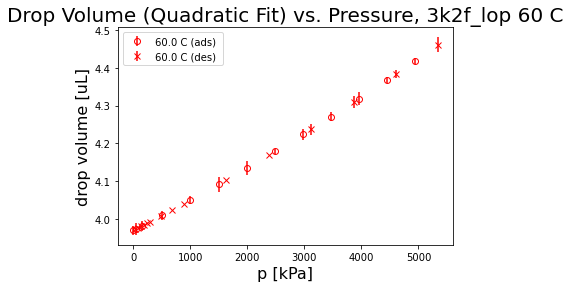

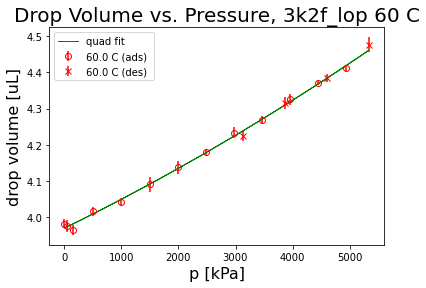

In [21]:
# Compute fitted drop volume and uncertainty [uL]
v_drop_fit, s_v_drop_fit = dataproc.fit_v_drop(p_plot, v_drop_eq, s_v_drop_eq)

# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_fit, s_v_drop_fit, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume (Quadratic Fit) vs. Pressure, %s %d C' % (polyol, T))

# plot equilibrium drop volume vs. p alongside the fit (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_v_drop_eq, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_plot, v_drop_fit, ax=ax, marker=None, lw=1, color='g', label='quad fit')
plt.legend()

# Use fitted drop volume to estimate the sample volume
v_samp_fit = v_drop_fit / v_drop_atm * v_samp_atm
s_v_samp_fit = errprop.error_v_samp(v_samp_fit, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref,
                                     v_drop_fit, s_v_drop_fit, v_drop_ref, s_v_drop_ref)

# use fit to estimate sample volume due to missing drop volume at low pressures during desorption
df['drop volume (fit) [uL]'] = v_drop_fit
df['drop volume (fit) std [uL]'] = s_v_drop_fit
df['sample volume (fit) [mL]'] = v_samp_fit
df['sample volume (fit) std [mL]'] = s_v_samp_fit

#### Plot adsorbed gas mass over time

Here we plot the adsorbed gas mass over time alongside the pressure to check for consistency. We also estimate the initial mass of gas adsorbed and the final mass of gas adsorbed.

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 50 kPa.
Pressure = 150 kPa.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3950 kPa.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Rejected 1 outliers.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 4450 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4950 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5350 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4600 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3850 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3100 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2400 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 1600 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 900 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 700 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 300 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 240 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 190 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 135 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 90 kPa.
Pressure = 37 kPa.


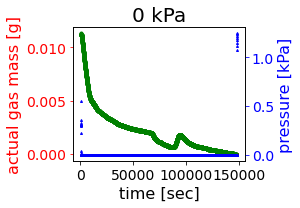

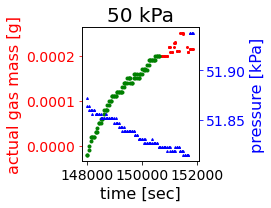

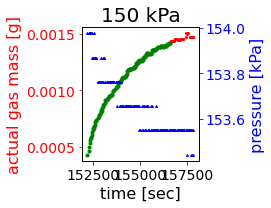

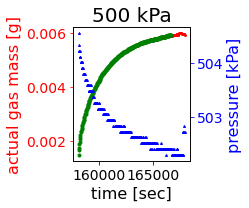

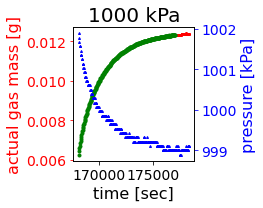

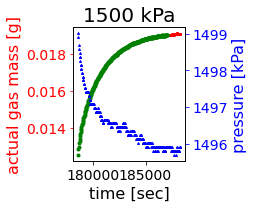

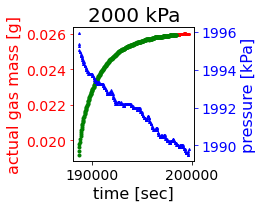

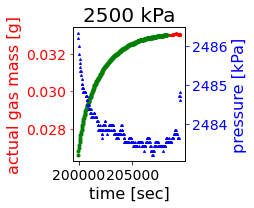

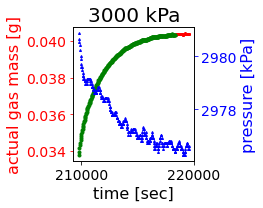

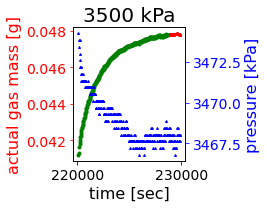

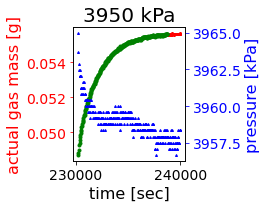

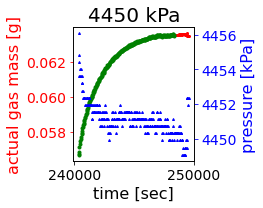

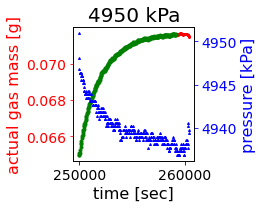

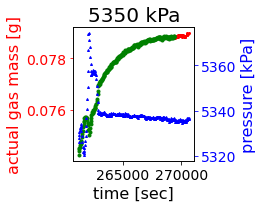

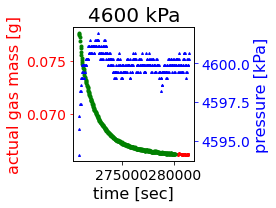

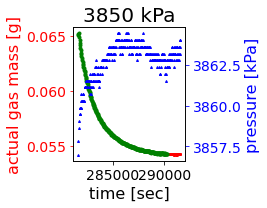

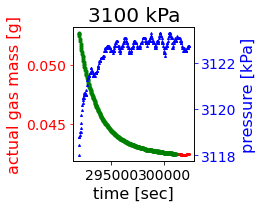

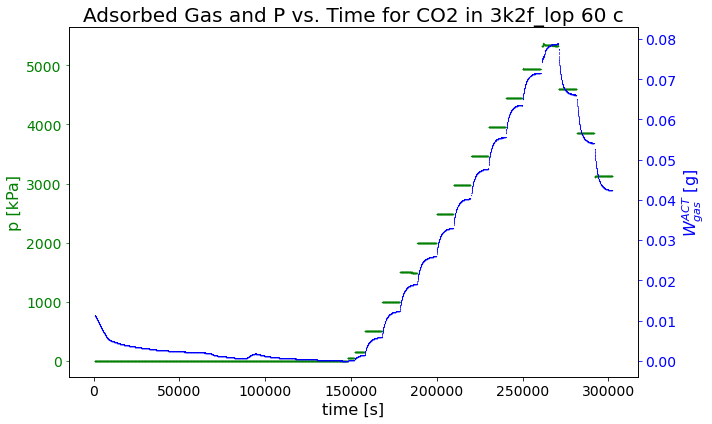

In [22]:
# number of seconds to define equilibrium
n_sec = 1200
# initalize marker for pressure bounds
last_bound = 0
# initialize arrays to store data
t_mp1_arr = np.array([])
w_gas_act_arr = np.array([])
p_mp1_arr = np.array([])

# set default mass of gas adsorbed in polyol to 0 and uncertainty to that of reference measurement [g]
df['M_0 (prev) [g]'] = np.zeros([len(p_set_arr)])
df['M_0 (prev) std [g]'] = s_w_gas_ref[0]*np.ones([len(p_set_arr)])

# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True, t_eq=n_sec)   


# skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # concatenate results to arrays
    t_mp1_arr = np.concatenate((t_mp1_arr, t_mp1))
    w_gas_act_arr = np.concatenate((w_gas_act_arr, w_gas_act))
    p_mp1_arr = np.concatenate((p_mp1_arr, p_mp1))
    # get indices to average the last given number of seconds
    inds_eq = np.where(t_mp1[-1] - t_mp1 <= n_sec)[0]
    inds_trans = np.where(t_mp1[-1] - t_mp1 > n_sec)[0]
    w_gas_act_eq = df['actual weight of dissolved gas [g]'].iloc[i]
    s_w_gas_act_eq = max(df['actual weight of dissolved gas std [g]'].iloc[i], s_w_gas_ref[0])
    # save new uncertainty
    df['actual weight of dissolved gas std [g]'].iloc[i] = s_w_gas_act_eq
    
    # plot dissolved gas for each pressure on same plot
    ax = plot.plot_two_axes(t_mp1[inds_eq], w_gas_act[inds_eq], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['gas mass', 'p'], xlabel='time [sec]', ms=2, 
                   ylabels=['actual gas mass [g]', 'pressure [kPa]'], title='%d kPa' % p_set)
    plot.plot_line(t_mp1[inds_trans], w_gas_act[inds_trans], color='g', ax=ax)
    
    # save gas mass from current run for next M_0 and uncertainty
    if i < len(p_set_arr)-1:
        df['M_0 (prev) [g]'].iloc[i+1] = w_gas_act_eq 
        df['M_0 (prev) std [g]'].iloc[i+1] = s_w_gas_act_eq 
    # save gas mass from current run for current M_infty and uncertainty
    df['M_infty (final) [g]'].iloc[i] = w_gas_act_eq 
    df['M_infty (final) std [g]'].iloc[i] = s_w_gas_act_eq 
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue
        
# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_mp1_arr, p_mp1_arr, w_gas_act_arr, markers=['o', '^'], labels=['p', r'$w_{gas}$'], figsize=(10,6),
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=['g', 'b'], ms=0.2,
                       xlabel='time [s]', ylabels=['p [kPa]', r'$W_{gas}^{ACT}$ [g]'])

# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

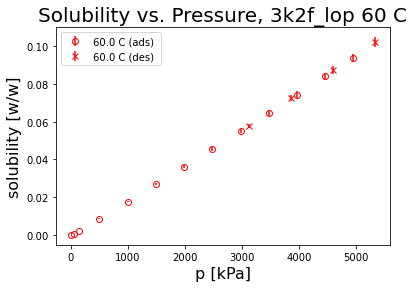

In [23]:
# COMPUTE AND PLOT SOLUBILITY

# load "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_gas_act = df['actual weight of dissolved gas [g]'].to_numpy(dtype=float)
# load buoyancy correction 
buoyancy = df['buoyancy correction [g]'].to_numpy(dtype=float)
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility, v_samp, buoyancy, w_gas_act, v_drop_eq, 
                                    s_v_drop_eq,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Literature Data

Since there are data in the literature from Guadagno and Kazarian (2004) *JPCB*, we will plot their results alongside ours. They took measurements of 2700 g/mol PPG with FTIR at 25 C and 35 C. We will also plot the values for PPG 2700 at 31.1 C for comparison.

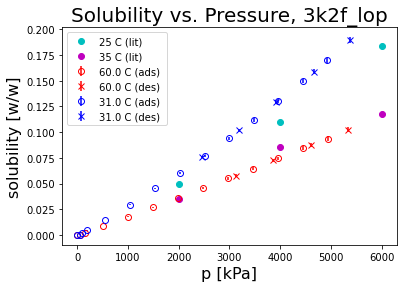

In [24]:
# plot data from Guadagno and Kazarian (2004) JPCB at 25 C and 35 C
p_lit = np.array([2000, 4000, 6000])
solubility_lit_25 = np.array([0.05, 0.11, 0.184])
solubility_lit_35 = np.array([0.035, 0.086, 0.118])

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s' % (polyol))
df_3k2f_31c = pd.read_csv(os.path.join(save_folder, '3k2f_31c.csv'))
p_plot_31c = df_3k2f_31c['p actual [kPa]'].to_numpy(dtype=float)
solubility_31c = df_3k2f_31c['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_31c = df_3k2f_31c['solubility error [w/w]'].to_numpy(dtype=float)
ax = plot.plot_errorbars_ads_des(p_plot_31c, solubility_31c, s_solubility_31c, p_plot_31c, 31, ax=ax, color='b')
ax = plot.plot_line(p_lit, solubility_lit_25, ax=ax, marker='o', color='c', label='25 C (lit)')
ax = plot.plot_line(p_lit, solubility_lit_35, ax=ax, marker='o', color='m', label='35 C (lit)')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_lit_data.pdf' % (polyol, T), bbox_inches='tight')

Our measurements clearly deviate from those of Guadagno and Kazarian.

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

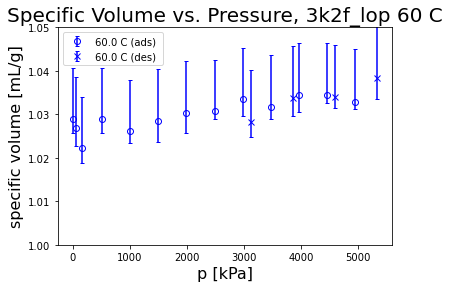

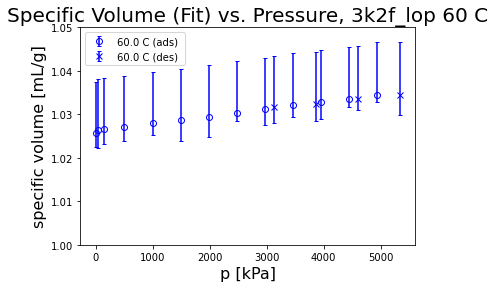

In [25]:
# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol
# also compute the specific volume based on the quadratic fit of the drop volume
spec_vol_fit = v_samp_fit / (w_gas_act + w_poly)
df['specific volume (fit) [mL/g]'] = spec_vol_fit

# propagate error to estimate uncertainty, distinguishing statistical and systematic
s_spec_vol_stat, s_spec_vol_sys = errprop.error_spec_vol_stat_sys(spec_vol, v_samp, buoyancy, w_gas_act, 
                                                                  v_drop_eq, s_v_drop_eq,  w_poly_arr, 
                                                                  s_frac_rho_co2, w_samp_ref, s_w_samp_ref, rho_samp_ref, 
                                                                  s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                                                  v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
# save separated statistical and systematic errors
s_spec_vol = np.sqrt(s_spec_vol_stat**2 + s_spec_vol_sys**2)
df['specific volume error [mL/g]'] = s_spec_vol
df['specific volume error (stat) [mL/g]'] = s_spec_vol_stat
df['specific volume error (sys) [mL/g]'] = s_spec_vol_sys


# Plot specific volume vs. pressure, stat is bottom error bar, sys is top
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.05])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure for fitted drop volumes
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol_fit, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.05])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_fit_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with low-temperature data for specific volume

We will also plot the low-temperature data alongside the high-temperature data for specific volume below.

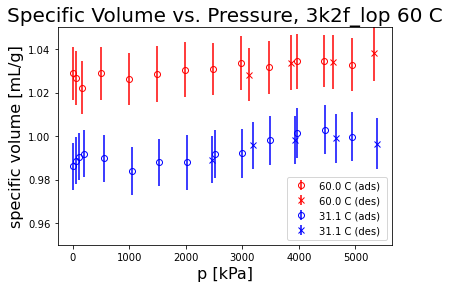

In [26]:
# Load low-temperature (31 C) data
df_31c = pd.read_csv(save_folder + '3k2f_31c.csv')
p_plot_31c = df_31c['p actual [kPa]'].to_numpy(dtype=float)
spec_vol_31c = df_31c['specific volume [mL/g]'].to_numpy(dtype=float)
s_spec_vol_31c = df_31c['specific volume error [mL/g]'].to_numpy(dtype=float)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_plot_31c, spec_vol_31c, s_spec_vol_31c, p_plot_31c, 31.1, ax=ax, color='b')
ax.set_ylim([0.95, 1.05])
plt.legend(loc=4)
# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_31c_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Distinguish Statistical and Systematic Uncertainties

As can be seen above, the statistical fluctuations in the specific volume measurements are much smaller than the error bars, which include systematic errors. Therefore, we hypothesize that the systematic errors are much larger. To represent this distinction, we plot them separately, with the systematic error on the first point and the systematic on the later points?

Having computed the specific volume, we store it as the sample density along with the density of the carbon dioxide atmosphere for use in FTA32 software to compute the interfacial tension properly.

In [27]:
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('adsa')] + 'adsa_densities.csv', index=False)

### Interfacial Tension

At this point, I use the program `auto_density_input_fta32.py` to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

Pressure = 0 kPa.
Rejected 1 outliers.
Interfacial tension = 25.660000 mN/m.
Pressure = 50 kPa.
********not enough ADSA points at given pressure.******
Interfacial tension data not stored.
Pressure = 150 kPa.
Interfacial tension = 25.472000 mN/m.
Pressure = 500 kPa.
Rejected 1 outliers.
Interfacial tension = 24.938000 mN/m.
Pressure = 1000 kPa.
Rejected 1 outliers.
Interfacial tension = 23.823000 mN/m.
Pressure = 1500 kPa.
Rejected 1 outliers.
Interfacial tension = 22.805000 mN/m.
Pressure = 2000 kPa.
Rejected 1 outliers.
Interfacial tension = 21.617000 mN/m.
Pressure = 2500 kPa.
Rejected 1 outliers.
Interfacial tension = 20.753000 mN/m.
Pressure = 3000 kPa.
Rejected 1 outliers.
Interfacial tension = 19.605000 mN/m.
Pressure = 3500 kPa.
Rejected 1 outliers.
Interfacial tension = 18.686000 mN/m.
Pressure = 3950 kPa.
Rejected 1 outliers.
Interfacial tension = 17.709000 mN/m.
Pressure = 4450 kPa.
Rejected 1 outliers.
Interfacial tension = 16.790000 mN/m.
Pressure = 4950 kPa.
Rejected 1 ou

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


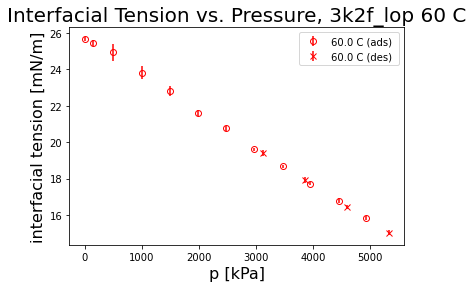

In [28]:
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        p_set = p_set_arr[i]
        print('Pressure = %d kPa.' % p_set)
        # get indices of each measurement with pressure within thresholds
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
        df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot Interfacial Tension Data for Different Temperatures

Because we have data for interfacial tension at 31.1 C for 3k2f polyol as well, we will plot the data from the two temperatures together.

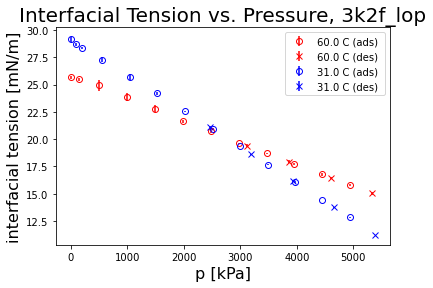

In [29]:
# has interfacial tension data been provided?
if len(if_tension) > 0:
    
    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    if_tension_31c = df_31c['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension_31c = df_31c['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s' % (polyol))
    ax = plot.plot_errorbars_ads_des(p_plot_31c, if_tension_31c, s_if_tension_31c, p_plot_31c, 31, ax=ax, color='b')

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_31c_%dc.pdf' % (polyol, T), bbox_inches='tight')

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

#### Fit Initial Time and Mass

Our first approach is to fit both the initial time of the sorption ($t_0$) and the initial mass ($M(t_0)$).

Pressure = 0 kPa.
Rejected 1 outliers.
Square-root fit could not converge.
Pressure = 50 kPa.
D_sqrt = 3.93e-05 cm^2/s.
Pressure = 150 kPa.
D_sqrt = 1.09e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 1.58e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 1.54e-05 cm^2/s.
Pressure = 1500 kPa.


../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b


Rejected 1 outliers.
D_sqrt = 1.69e-05 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 1.70e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.49e-05 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 1.42e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 1.64e-05 cm^2/s.
Pressure = 3950 kPa.
Rejected 1 outliers.
D_sqrt = 1.62e-05 cm^2/s.
Pressure = 4450 kPa.
Rejected 1 outliers.
D_sqrt = 1.93e-05 cm^2/s.


../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b


Pressure = 4950 kPa.
Rejected 1 outliers.
D_sqrt = 2.11e-05 cm^2/s.
Pressure = 5350 kPa.
Rejected 1 outliers.
D_sqrt = 2.45e-06 cm^2/s.
Pressure = 4600 kPa.
Rejected 1 outliers.
D_sqrt = 2.09e-05 cm^2/s.
Pressure = 3850 kPa.
Rejected 1 outliers.
D_sqrt = 2.61e-05 cm^2/s.
Pressure = 3100 kPa.
Rejected 1 outliers.
D_sqrt = 1.97e-05 cm^2/s.
Pressure = 2400 kPa.
Rejected 1 outliers.
Pressure = 1600 kPa.
Rejected 1 outliers.
Pressure = 900 kPa.
Rejected 1 outliers.
Pressure = 700 kPa.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Pressure = 300 kPa.
Rejected 1 outliers.
Pressure = 240 kPa.
Rejected 1 outliers.
Pressure = 190 kPa.
Rejected 1 outliers.
Pressure = 135 kPa.
Rejected 1 outliers.
Pressure = 90 kPa.
Pressure = 37 kPa.


../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


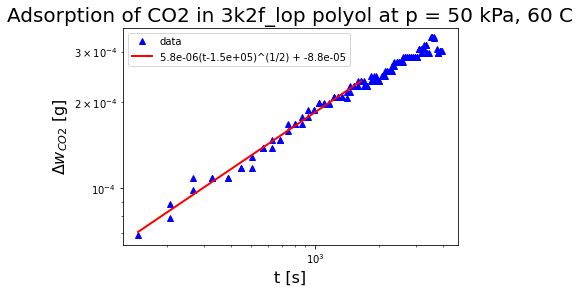

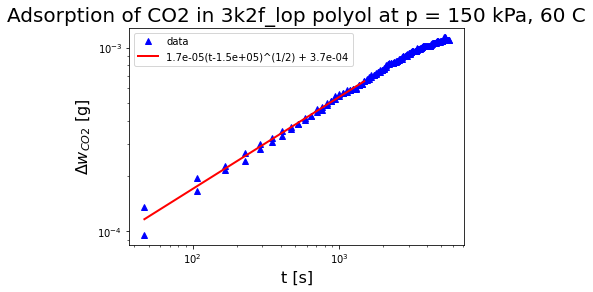

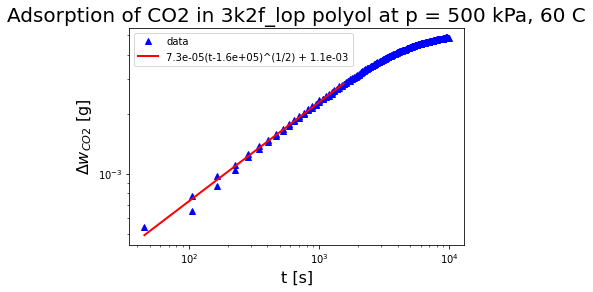

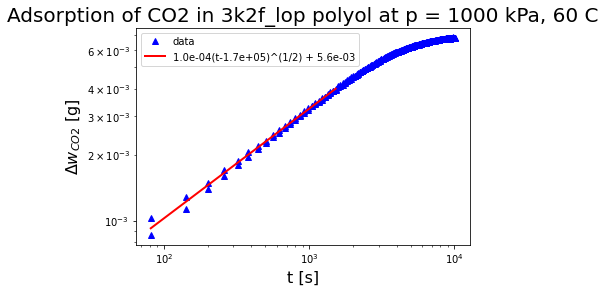

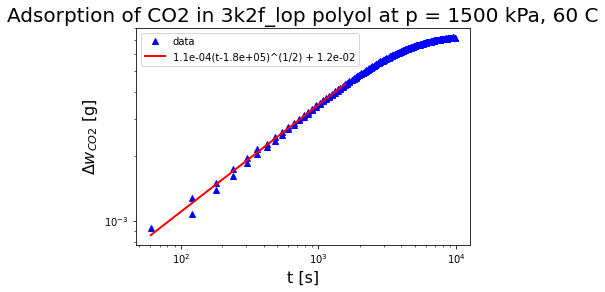

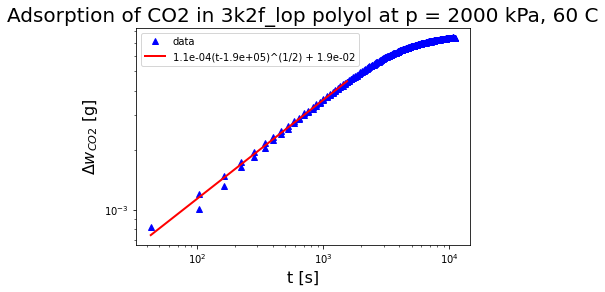

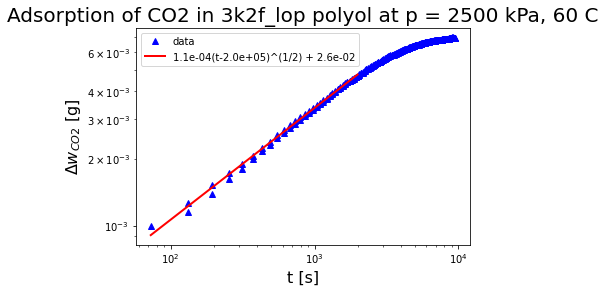

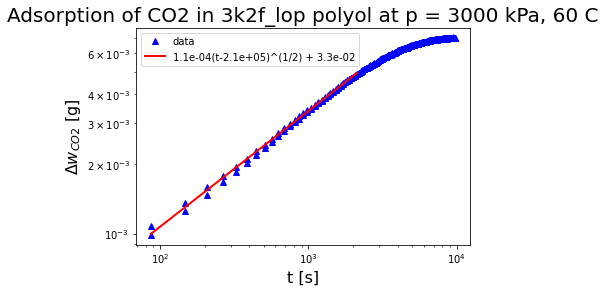

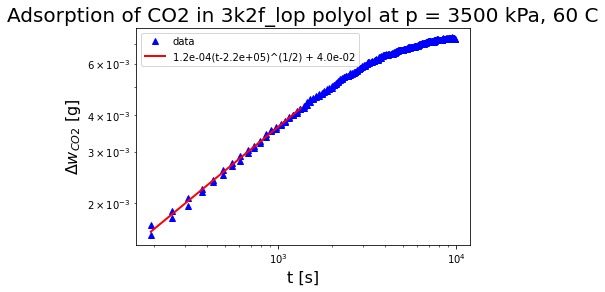

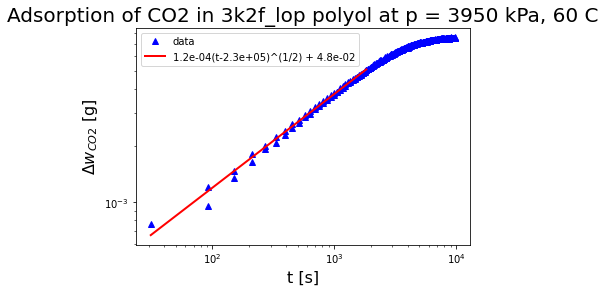

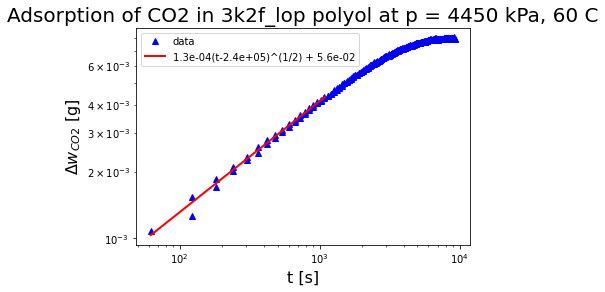

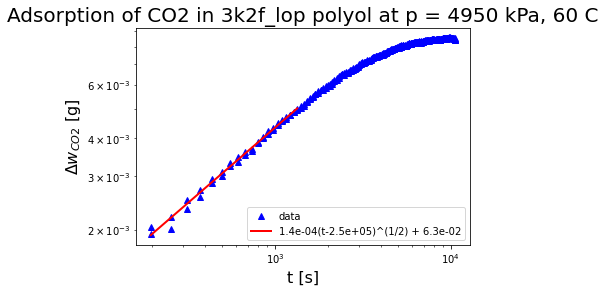

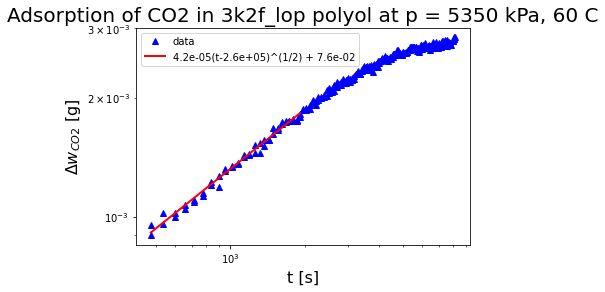

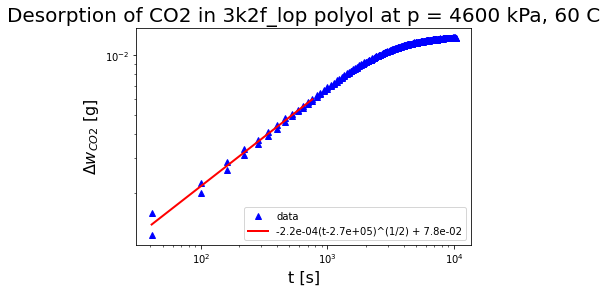

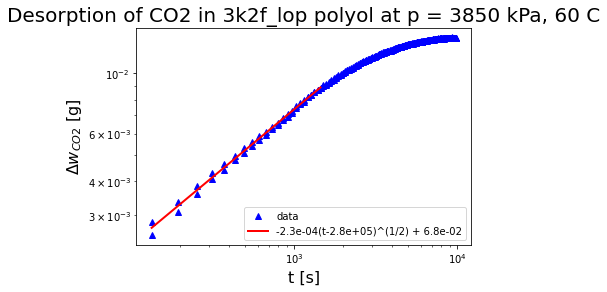

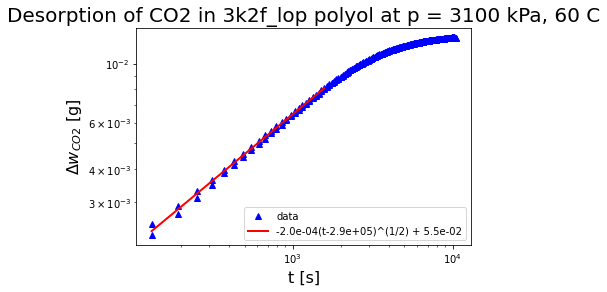

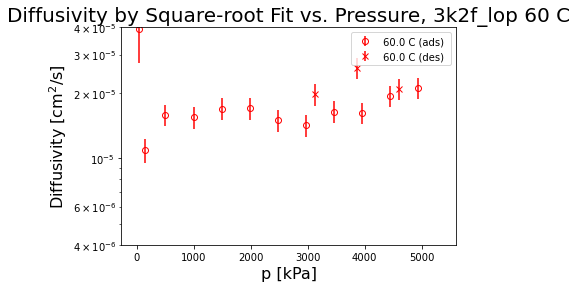

In [30]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:150, 3:500, 4:1000, 5:1500, 6:2000, 7:2500, 8:3000, 9:3500, 10:3950, 11:4450,
#                        12:4950, 13:5350, 14:4600, 15:3850, 16:3100, 17:2400, 18:1600, 19:900, 20:700, 21:500, 
#                       22:300, 23:240, 24:190, 25:135, 26:90, 27:37])
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[7] = 65 # 70 # 80
n_pts_sqrt_arr[8] = 70 # 40
n_pts_sqrt_arr[9] = 40
n_pts_sqrt_arr[10] = 60 # 40 # 65 # 70
n_pts_sqrt_arr[11] = 35
n_pts_sqrt_arr[12] = 40
n_pts_sqrt_arr[14] = 25
n_pts_sqrt_arr[15] = 45 # 60  # 30 # 15
n_pts_sqrt_arr[16] = 50 # 75 # 60 #35 # 20 
n_pts_sqrt_arr[17] = 40
n_pts_sqrt_arr[18] = 78 # 70 # 90 # 80 # 60
n_pts_sqrt_arr[19] = 60 # 70 # 15 # 55 # 40 # 60
n_pts_sqrt_arr[20] = 65 # 70 # 15 # 32 # 25 # 40
n_pts_sqrt_arr[21] = 80 # 70 # 60
n_pts_sqrt_arr[22] = 60
n_pts_sqrt_arr[23] = 40 # 80 # 70 # 50
n_pts_sqrt_arr[24] = 70 # 50
n_pts_sqrt_arr[25] = 60 # 40
n_pts_sqrt_arr[26] = 30 # 35 # 45 # 60 # 40
n_pts_sqrt_arr[27] = 60 # 40 
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[7] = 3
i_shift[8] = 3
i_shift[9] = 5
i_shift[13] = 60
i_shift[14] = 3
i_shift[15] = 2
i_shift[16] = 2
i_shift[17] = 3
i_shift[18] = 5
i_shift[19] = 3
i_shift[20] = 3
i_shift[27] = 5

# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit both initial time t0 and initial mass w0
D_sqrt_2fit_arr, M_0_extrap_2fit_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav, polyol, 
                                                                                 T, p_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                                 p_thresh_frac, v_ref_he, i_shift, 
                                                                                 maxfev, diam_cruc, fit_t0=True, fit_w0=True)
# Define uncertainties for the first calculation
M_0 = df['M_0 (prev) [g]'].to_numpy(dtype=float)
M_infty = df['M_infty (final) [g]'].to_numpy(dtype=float)
s_M_0 = df['M_0 (prev) std [g]'].to_numpy(dtype=float)
s_M_infty = df['M_infty (final) std [g]'].to_numpy(dtype=float)

# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_2fit_arr = errprop.error_D_sqrt(D_sqrt_2fit_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_2fit_arr, s_D_sqrt_2fit_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[4E-6, 4E-5],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_2fit_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Fit Initial Mass

Next we will estimate the diffusivity by fitting the initial mass at the initial time $t_0$ but estimating the initial time $t_0$ as the last time point of the previous pressure step.

Pressure = 0 kPa.
Rejected 1 outliers.
Square-root fit could not converge.
Pressure = 50 kPa.
D_sqrt = 3.76e-05 cm^2/s.
Pressure = 150 kPa.
D_sqrt = 1.91e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 2.01e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 2.18e-05 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 2.26e-05 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 2.36e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 2.11e-05 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 2.07e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 2.87e-05 cm^2/s.
Pressure = 3950 kPa.
Rejected 1 outliers.
D_sqrt = 2.38e-05 cm^2/s.
Pressure = 4450 kPa.
Rejected 1 outliers.
D_sqrt = 3.03e-05 cm^2/s.
Pressure = 4950 kPa.
Rejected 1 outliers.
D_sqrt = 2.88e-05 cm^2/s.
Pressure = 5350 kPa.
Rejected 1 outliers.
D_sqrt = 7.06e-06 cm^2/s.
Pressure = 4600 kPa.
Rejected 1 outliers.
D_sqrt = 4.11e-05 cm^2/s.
Pressure = 3850 kPa

../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


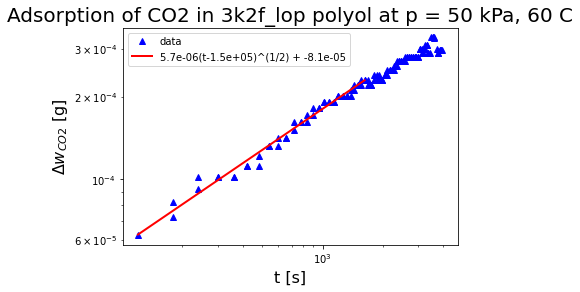

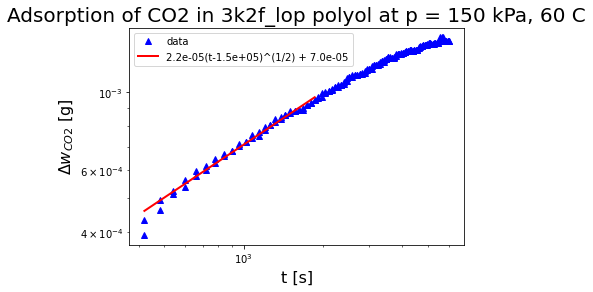

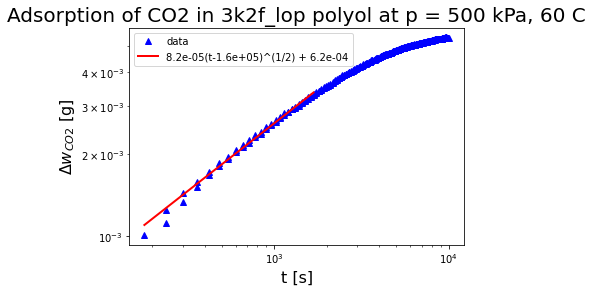

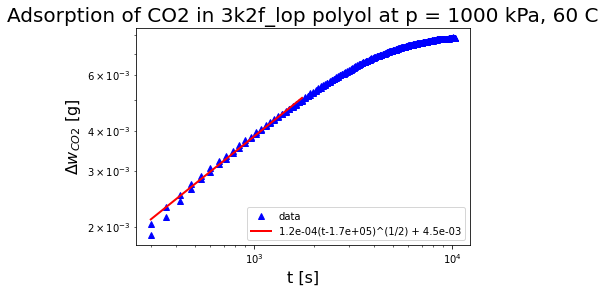

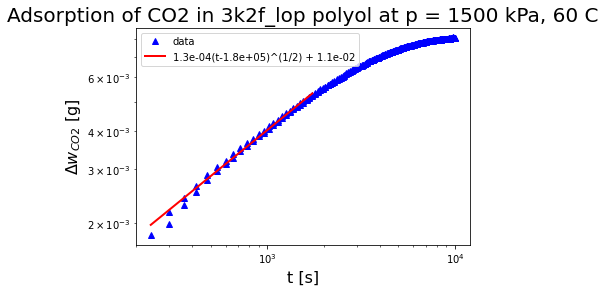

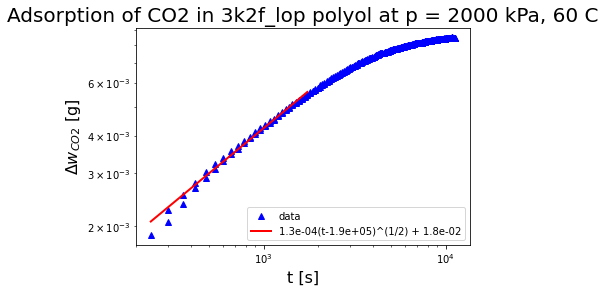

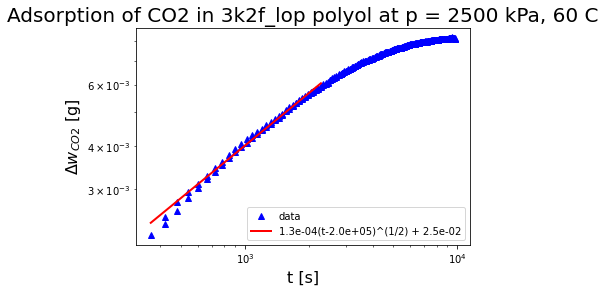

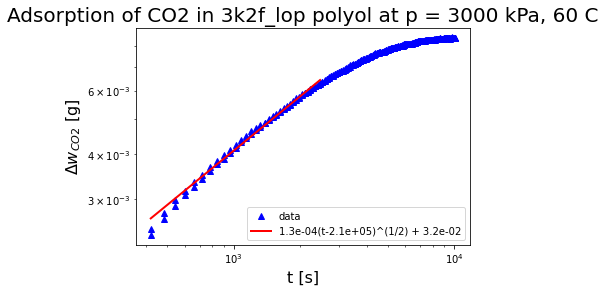

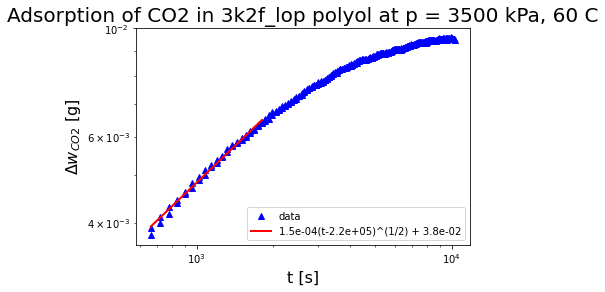

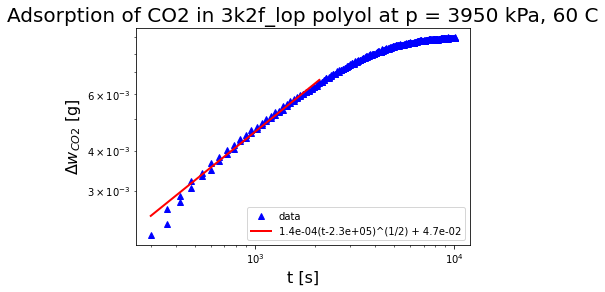

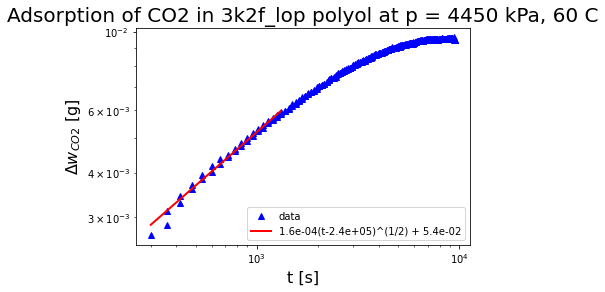

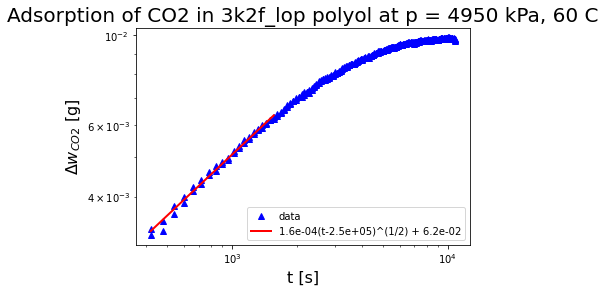

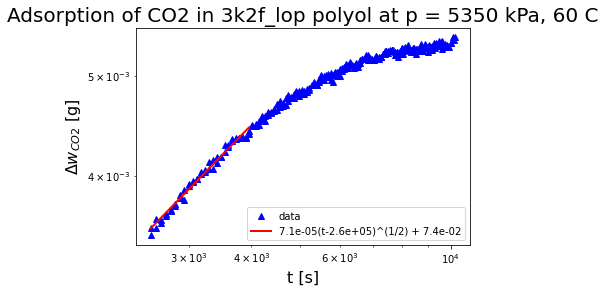

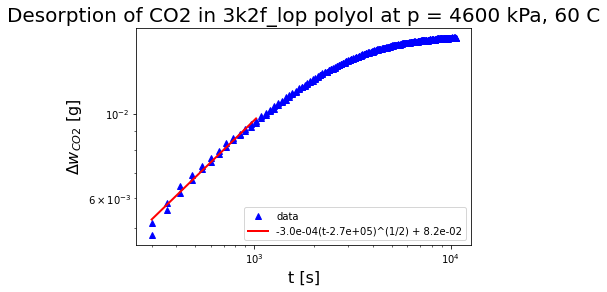

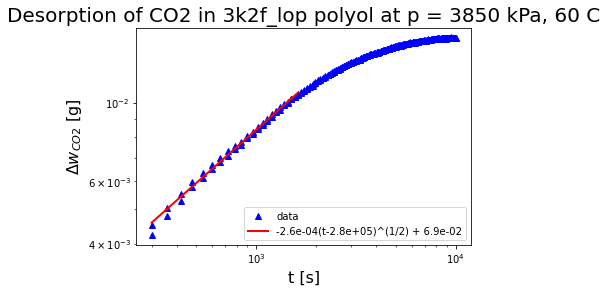

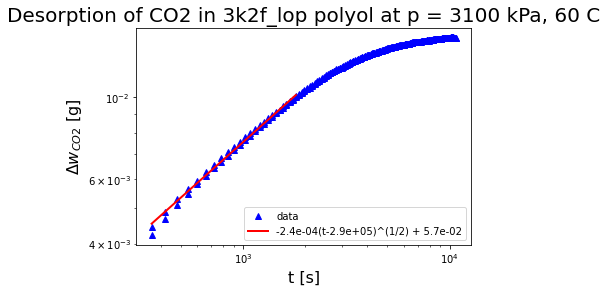

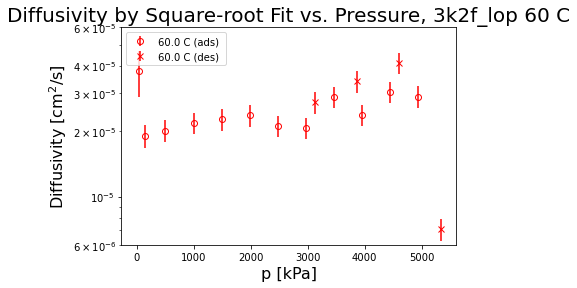

In [32]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:150, 3:500, 4:1000, 5:1500, 6:2000, 7:2500, 8:3000, 9:3500, 10:3950, 11:4450,
#                        12:4950, 13:5350, 14:4600, 15:3850, 16:3100])

# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit initial mass but use last time point of previous experiment as initial time t0
D_sqrt_fitw0_arr, M_0_extrap_fitw0_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=False, fit_w0=True)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fitw0_arr = errprop.error_D_sqrt(D_sqrt_fitw0_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitw0_arr, s_D_sqrt_fitw0_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[6E-6, 6E-5],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fitw0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Fit Initial Time

In this rendition of the diffusivity calculation, we fit the initial time $t_0$ and estimate the mass at the initial time $M(t_0)$ to be the mass of gas measured at the end of the previous pressure step.

Pressure = 0 kPa.
Rejected 1 outliers.
Square-root fit could not converge.
Pressure = 50 kPa.
D_sqrt = 1.57e-05 cm^2/s.
Pressure = 150 kPa.
D_sqrt = 1.53e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 1.26e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 1.28e-05 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 1.39e-05 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 1.36e-05 cm^2/s.


../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)


Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.55e-05 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 1.59e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 1.71e-05 cm^2/s.
Pressure = 3950 kPa.
Rejected 1 outliers.
D_sqrt = 1.79e-05 cm^2/s.
Pressure = 4450 kPa.
Rejected 1 outliers.
D_sqrt = 1.93e-05 cm^2/s.
Pressure = 4950 kPa.
Rejected 1 outliers.
D_sqrt = 1.79e-05 cm^2/s.


../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)


Pressure = 5350 kPa.
Rejected 1 outliers.
D_sqrt = 1.14e-05 cm^2/s.
Pressure = 4600 kPa.
Rejected 1 outliers.
D_sqrt = 2.35e-05 cm^2/s.
Pressure = 3850 kPa.
Rejected 1 outliers.
D_sqrt = 1.84e-05 cm^2/s.
Pressure = 3100 kPa.
Rejected 1 outliers.
D_sqrt = 1.68e-05 cm^2/s.
Pressure = 2400 kPa.
Rejected 1 outliers.
Pressure = 1600 kPa.
Rejected 1 outliers.
Pressure = 900 kPa.
Rejected 1 outliers.
Pressure = 700 kPa.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Pressure = 300 kPa.
Rejected 1 outliers.
Pressure = 240 kPa.
Rejected 1 outliers.
Pressure = 190 kPa.
Rejected 1 outliers.
Pressure = 135 kPa.
Rejected 1 outliers.
Pressure = 90 kPa.
Pressure = 37 kPa.


../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


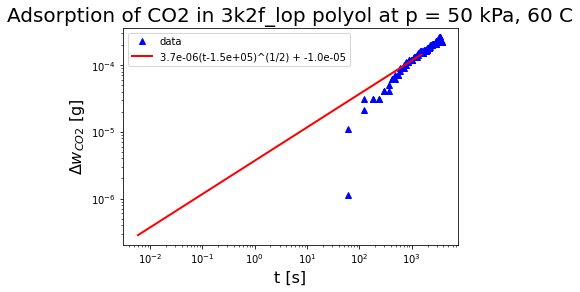

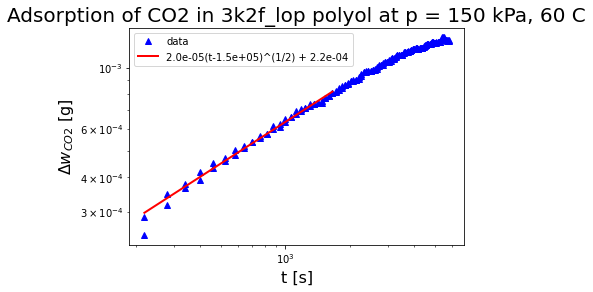

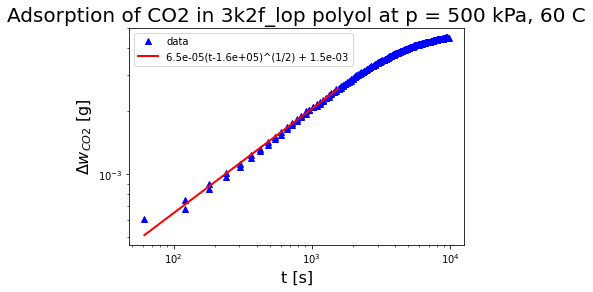

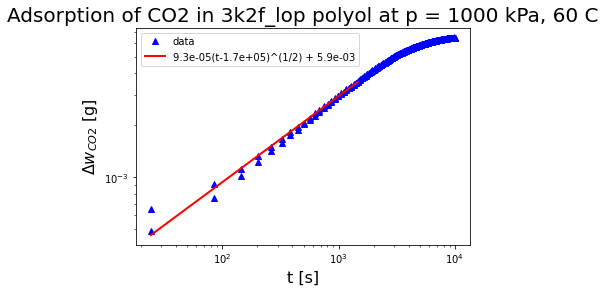

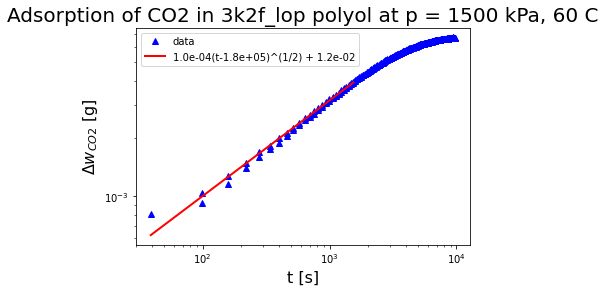

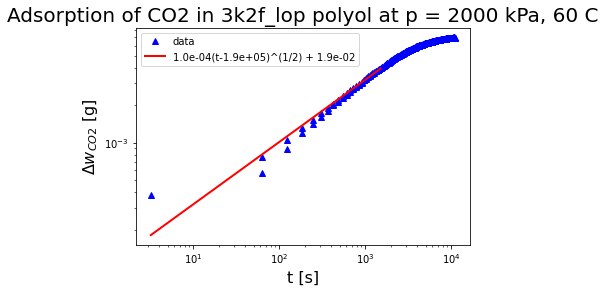

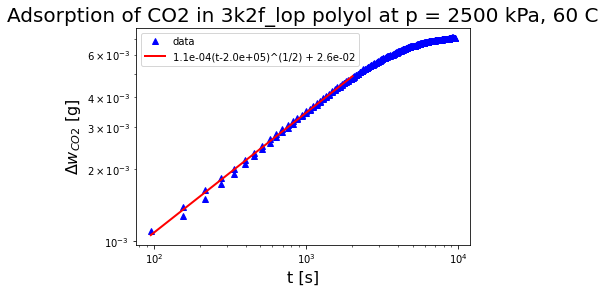

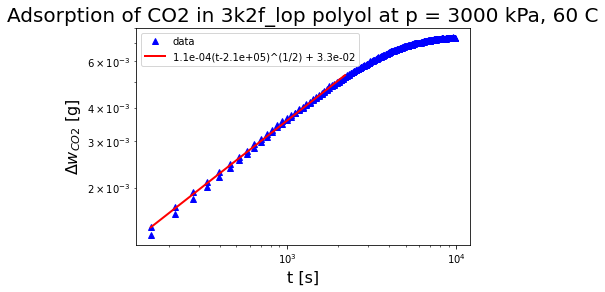

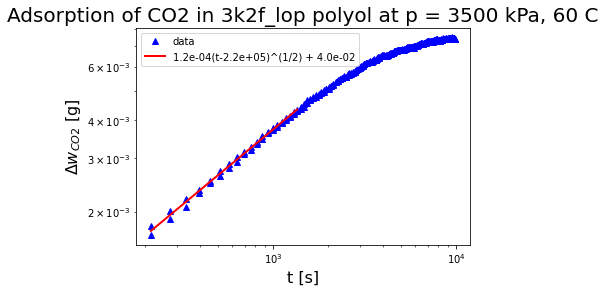

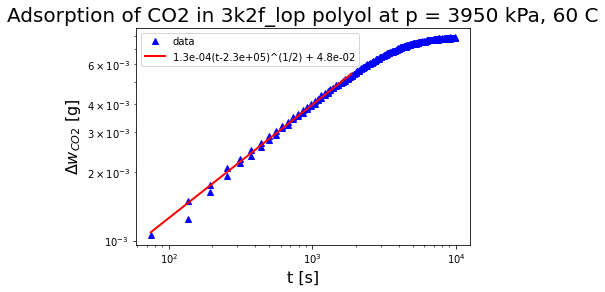

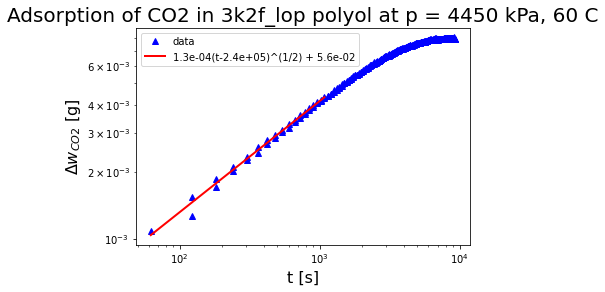

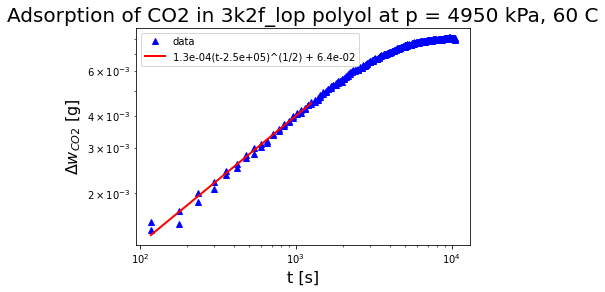

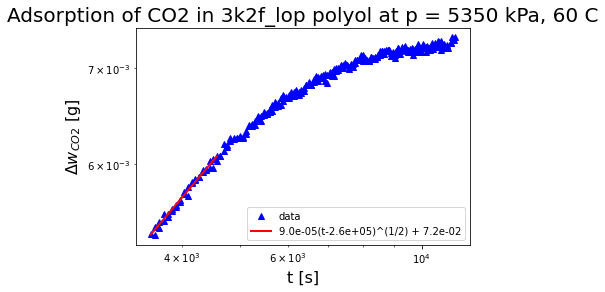

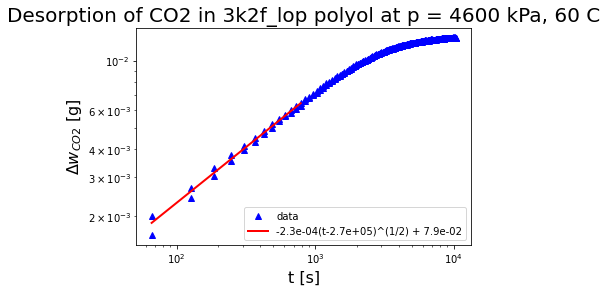

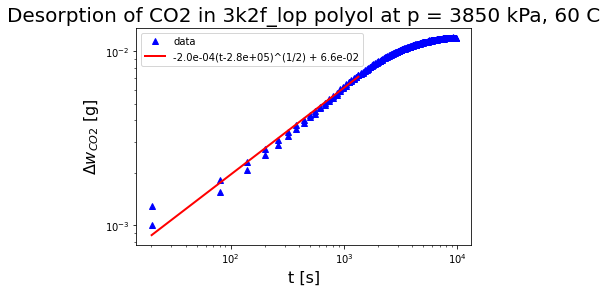

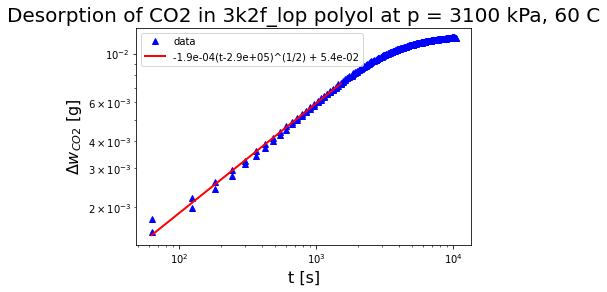

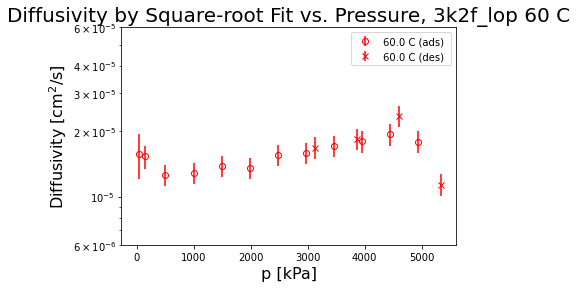

In [33]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:150, 3:500, 4:1000, 5:1500, 6:2000, 7:2500, 8:3000, 9:3500, 10:3950, 11:4450,
#                        12:4950, 13:5350, 14:4600, 15:3850, 16:3100, 17:2400, 18:1600, 19:900, 20:700, 21:500, 
#                       22:300, 23:240, 24:190, 25:135, 26:90, 27:37])
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr[13] = 35
n_pts_sqrt_arr[24] = 30 
n_pts_sqrt_arr[25:] = 20

# update shift in starting index of points to fit
i_shift[3] = 5
i_shift[5] = 3
i_shift[13] = 57
i_shift[25:] = 6

# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit initial mass but use last time point of previous experiment as initial time t0
D_sqrt_fitt0_arr, M_0_extrap_fitt0_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=True, fit_w0=False)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fitt0_arr = errprop.error_D_sqrt(D_sqrt_fitt0_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[6E-6, 6E-5],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fitt0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Fix (Not Fit) the Initial Mass and Initial Time

As a final comparison, we calculate the diffusivity using estimates of the initial time and mass from the experiment, where the initial time is the last time point measured in the previous pressure step and the initial mass of adsorbed gas is that at the end of the previous pressure step.

Pressure = 0 kPa.
Rejected 1 outliers.
Square-root fit could not converge.
Pressure = 50 kPa.
D_sqrt = 1.33e-05 cm^2/s.
Pressure = 150 kPa.
D_sqrt = 1.26e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 9.66e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 9.21e-06 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 1.03e-05 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 1.02e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.24e-05 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 1.29e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 1.08e-05 cm^2/s.
Pressure = 3950 kPa.
Rejected 1 outliers.
D_sqrt = 1.45e-05 cm^2/s.
Pressure = 4450 kPa.
Rejected 1 outliers.
D_sqrt = 1.36e-05 cm^2/s.
Pressure = 4950 kPa.
Rejected 1 outliers.
D_sqrt = 1.23e-05 cm^2/s.
Pressure = 5350 kPa.
Rejected 1 outliers.
D_sqrt = 1.59e-05 cm^2/s.
Pressure = 4600 kPa.
Rejected 1 outliers.
D_sqrt = 1.47e-05 cm^2/s.
Pressure = 3850 kPa

../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


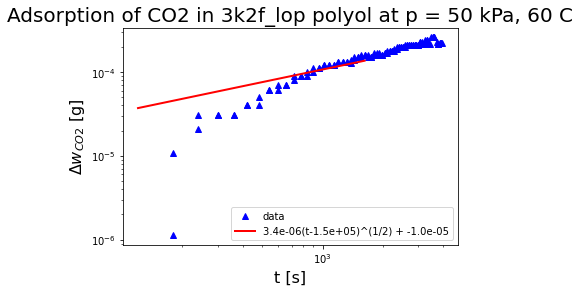

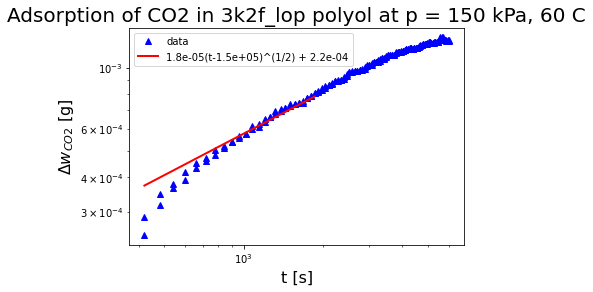

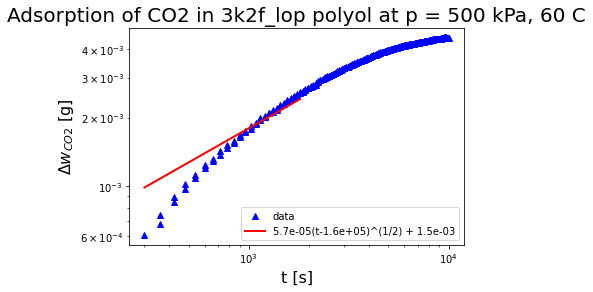

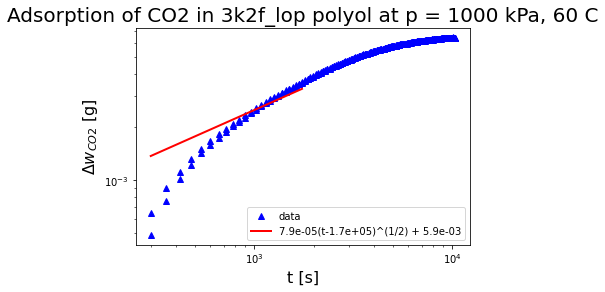

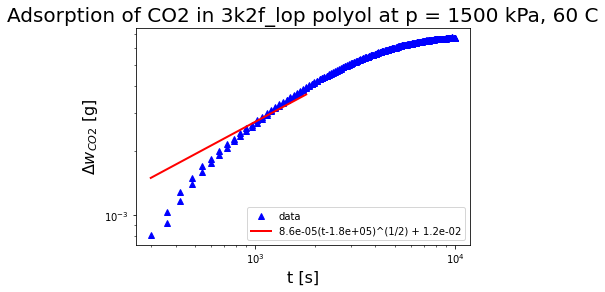

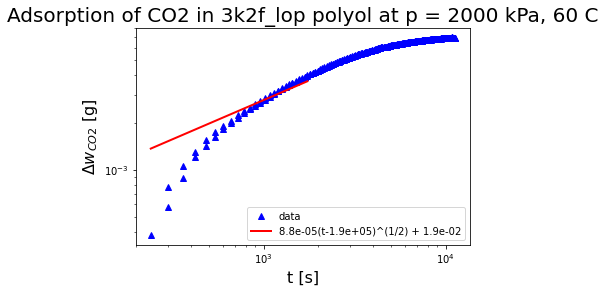

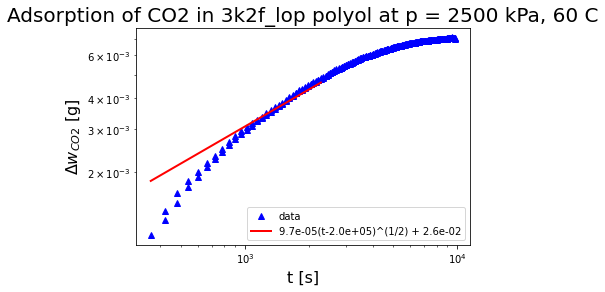

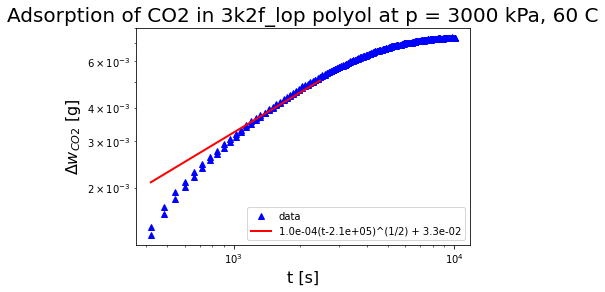

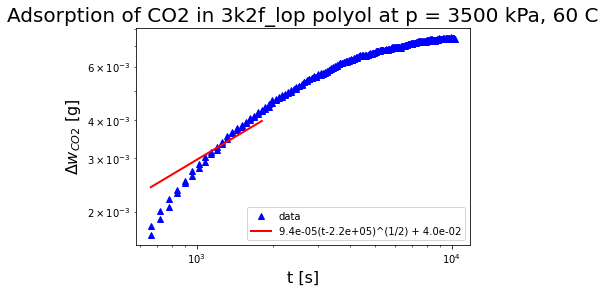

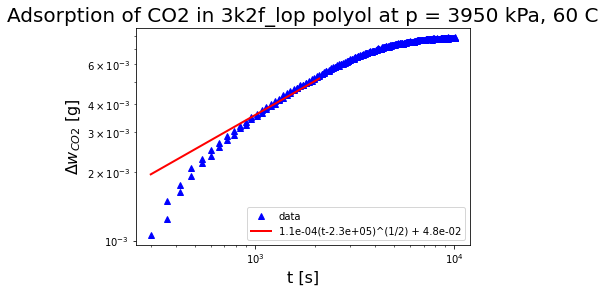

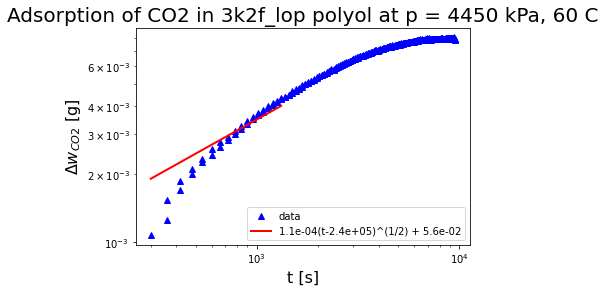

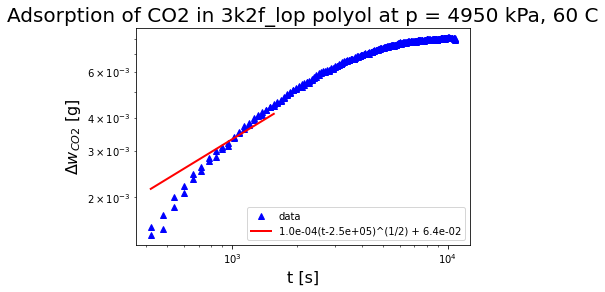

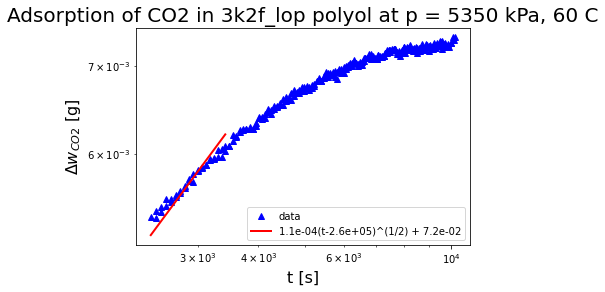

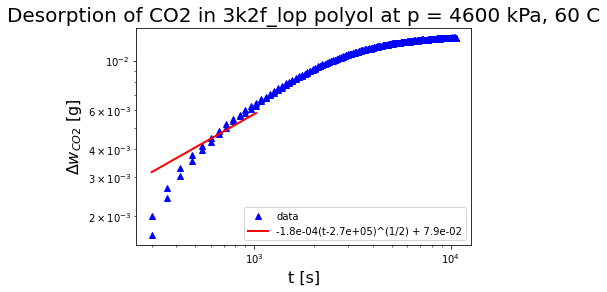

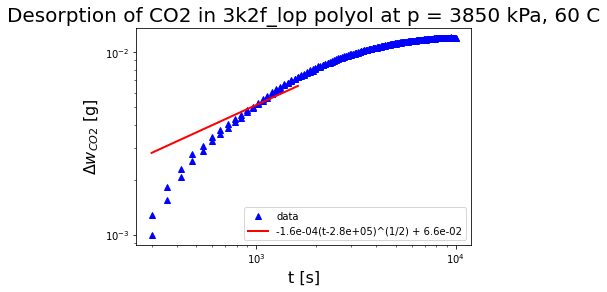

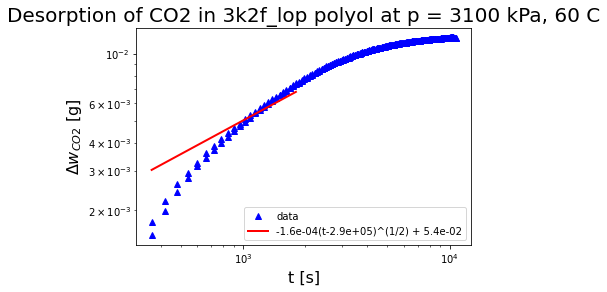

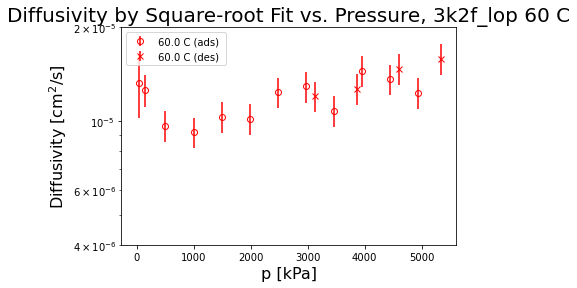

In [34]:
# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# use time and mass at end of previous pressure step as estiamtes of initial time and mass
D_sqrt_fixed_arr, M_0_extrap_fixed_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=False, fit_w0=False)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fixed_arr = errprop.error_D_sqrt(D_sqrt_fixed_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fixed_arr, s_D_sqrt_fixed_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[4E-6, 2E-5],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fixed_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Different Types of Square-root Fits

Below we compare the diffusivities calculated using each of the fits considered above.

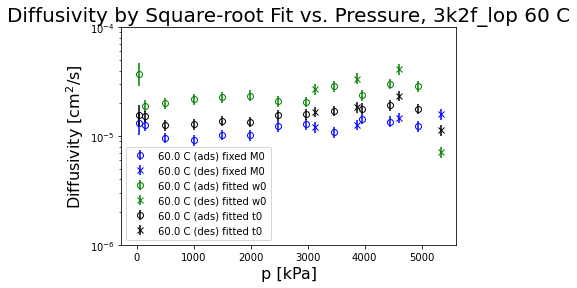

In [35]:
# Plot diffusivity vs. pressure for fixed M_0 and t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fixed_arr, s_D_sqrt_fixed_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='fixed M0',
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# Plot diffusivity vs. pressure for fitted M_0 and fixed t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitw0_arr, s_D_sqrt_fitw0_arr, p_set_arr, T, ax=ax, color='g',
                                label_tag='fitted w0') 
# Plot diffusivity vs. pressure for fixed M_0 and fitted t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, ax=ax, 
                                 color='k', label_tag='fitted t0') 

save_plots=False
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_comparison_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Save Results

The fitted w0 looks the least variable, but for consistency we will use the fitted t0 values as were done for the 1k2f 30 C.

In [36]:
# save results to dataframe
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_fitt0_arr
df['diffusivity (sqrt) std [cm^2/s]'] = s_D_sqrt_fitt0_arr
df['M_0 (extrap) [g]'] = M_0_extrap_fitt0_arr

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

*Note that the change in $h_{samp}$ during the course of a pressure step is negligible relative to the error in the fitted parameter $B$ (at most 2%).*

Pressure = 0 kPa.
Rejected 1 outliers.
D_exp = 1.20e-06 cm^2/s.
Pressure = 50 kPa.
D_exp = 3.23e-05 cm^2/s.
Pressure = 150 kPa.
D_exp = 1.24e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_exp = 1.79e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_exp = 1.30e-05 cm^2/s.


../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:487: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


Pressure = 1500 kPa.
Rejected 1 outliers.
D_exp = 1.33e-05 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_exp = 1.09e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_exp = 1.50e-05 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_exp = 1.57e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_exp = 1.69e-05 cm^2/s.
Pressure = 3950 kPa.
Rejected 1 outliers.
D_exp = 1.73e-05 cm^2/s.
Pressure = 4450 kPa.
Rejected 1 outliers.
D_exp = 2.01e-05 cm^2/s.
Pressure = 4950 kPa.
Rejected 1 outliers.
D_exp = 1.56e-05 cm^2/s.
Pressure = 5350 kPa.
Rejected 1 outliers.
D_exp = 1.65e-05 cm^2/s.
Pressure = 4600 kPa.
Rejected 1 outliers.
D_exp = 2.06e-05 cm^2/s.
Pressure = 3850 kPa.
Rejected 1 outliers.
D_exp = 1.97e-05 cm^2/s.
Pressure = 3100 kPa.
Rejected 1 outliers.
D_exp = 1.77e-05 cm^2/s.
Pressure = 2400 kPa.
Rejected 1 outliers.
Pressure = 1600 kPa.
Rejected 1 outliers.
Pressure = 900 kPa.
Rejected 1 outliers.
Pressure = 700 kPa.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1

../src\errprop.py:38: RuntimeWarning: invalid value encountered in true_divide
  s_D_exp = D_exp*norm( (2*s_h_samp/h_samp, s_b/b) )


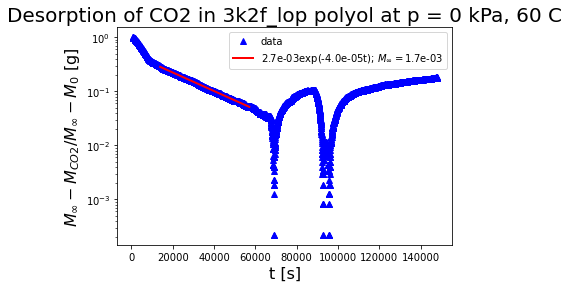

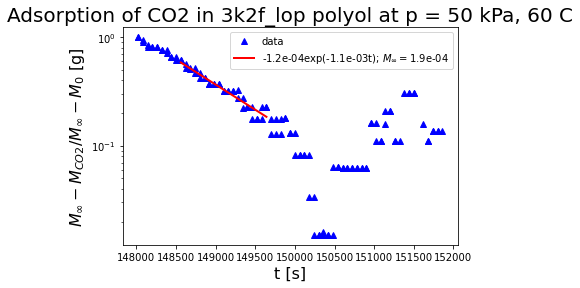

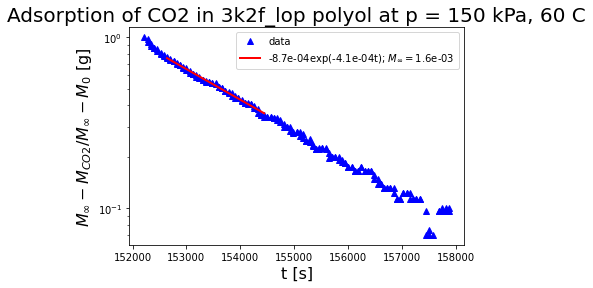

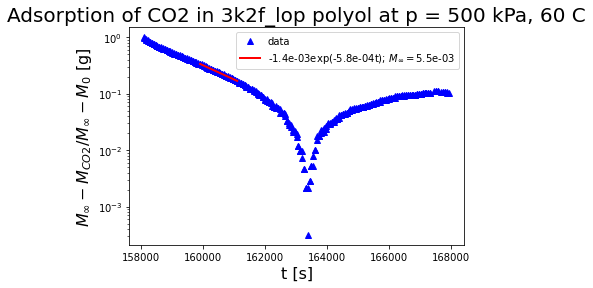

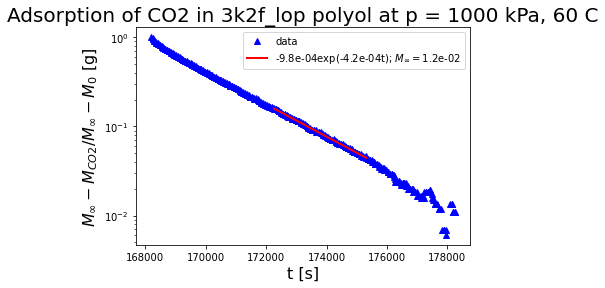

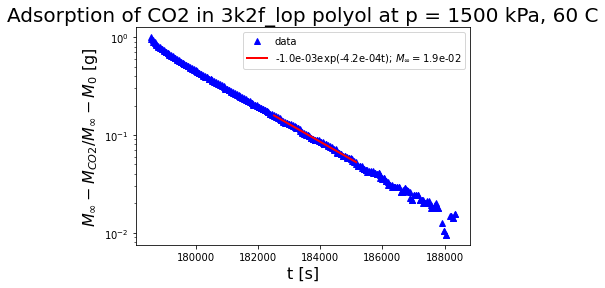

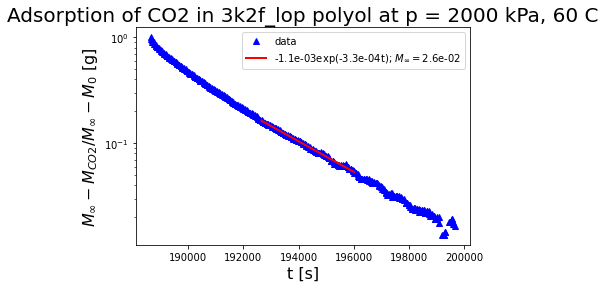

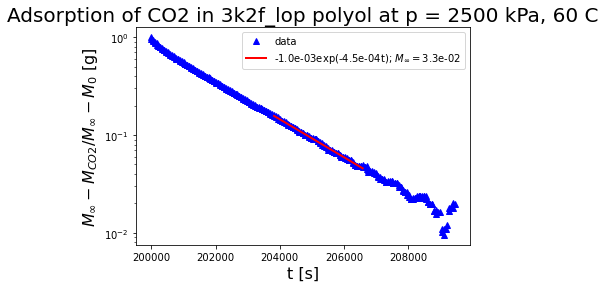

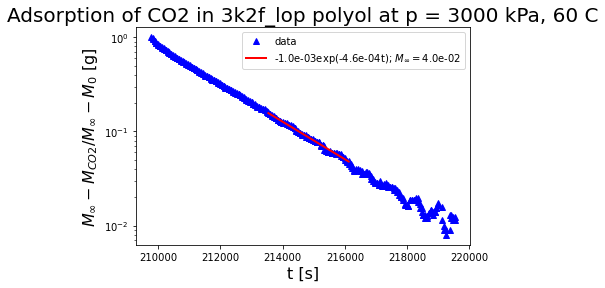

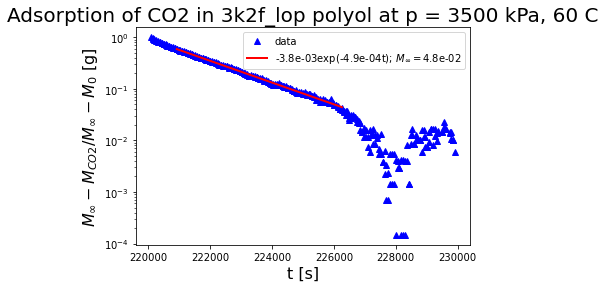

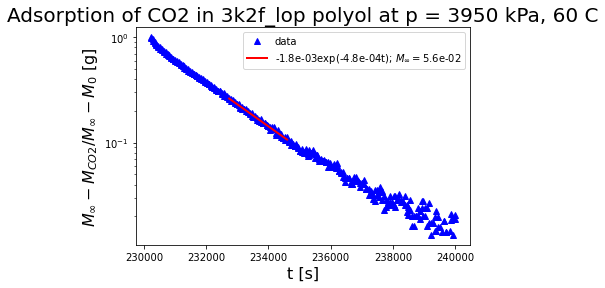

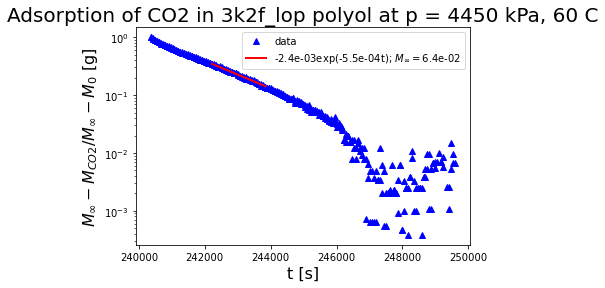

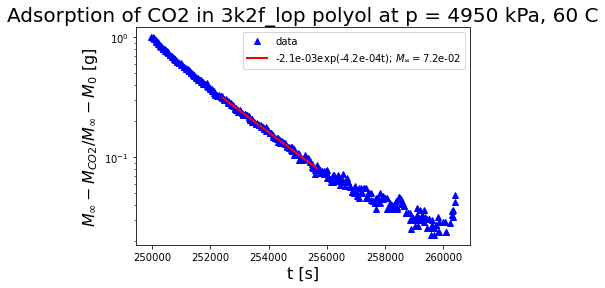

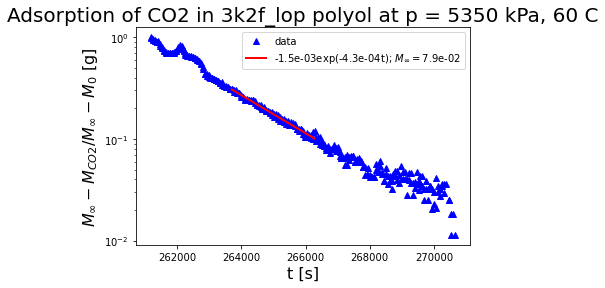

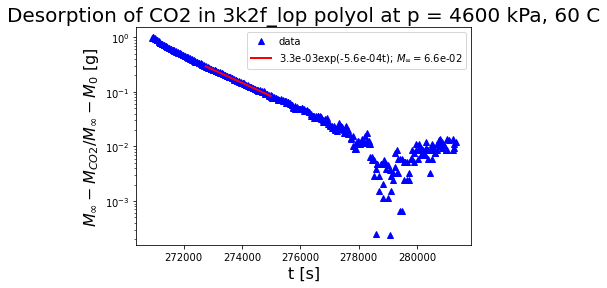

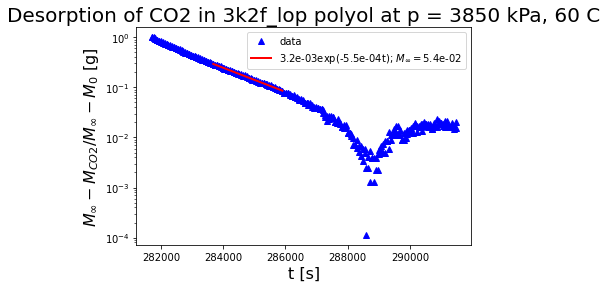

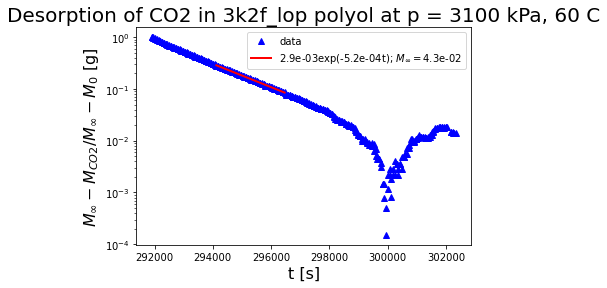

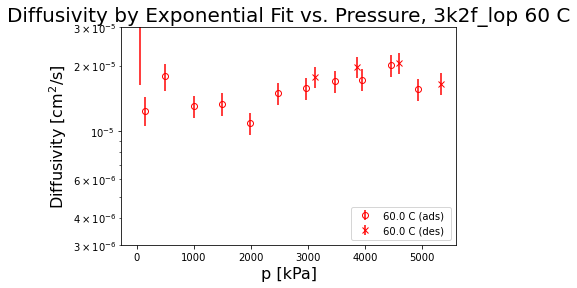

In [37]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:150, 3:500, 4:1000, 5:1500, 6:2000, 7:2500, 8:3000, 9:3500, 10:3950, 11:4450,
#                        12:4950, 13:5350, 14:4600, 15:3850, 16:3100, 17:2400, 18:1600, 19:900, 20:700, 21:500, 
#                       22:300, 23:240, 24:190, 25:135, 26:90, 27:37])

# thresholds for fraction of remaining gas mass to include in fit
thresh0_arr = 0.15*np.ones([len(p_set_arr)])
thresh1_arr = 0.04*np.ones([len(p_set_arr)])
# individualized thresholds
thresh0_arr[0] = 0.4 # 0
thresh1_arr[0] = 0.2 # 0
thresh0_arr[1] = 0.7 # 50 kPa
thresh1_arr[1] = 0.4 # 50 kPa
thresh0_arr[2] = 0.75 # 150 kPa
thresh1_arr[2] = 0.3 # 150 kPa
thresh0_arr[3] = 0.4 # 200 kPa
thresh1_arr[3] = 0.25 # 200 kPa
thresh0_arr[9] = 0.6 # 3500 kPa
thresh1_arr[9] = 0.06 # 3500 kPa
thresh0_arr[10] = 0.25
thresh1_arr[10] = 0.1
thresh0_arr[11] = 0.35
thresh1_arr[11] = 0.15
thresh0_arr[12] = 0.3 # 4950
thresh1_arr[12] = 0.06 # 4950
thresh0_arr[13] = 0.3 # 5350
thresh1_arr[13] = 0.1 # 5350
thresh0_arr[14] = 0.3
thresh1_arr[14] = 0.1
thresh0_arr[15] = 0.3
thresh1_arr[15] = 0.1
thresh0_arr[16] = 0.3 # 900 kPa
thresh1_arr[16] = 0.1 # 900 kPa
thresh0_arr[20] = 0.4 # 700
thresh1_arr[20] = 0.1 # 700
thresh0_arr[23] = 0.75 # 240
thresh1_arr[23] = 0.25 # 240
thresh0_arr[24] = 0.5 # 190
thresh1_arr[24] = 0.2 # 190
thresh0_arr[25] = 0.6 # 135
thresh1_arr[25] = 0.1 # 135
thresh0_arr[26] = 0.6 # 90
thresh1_arr[26] = 0.1 # 90
thresh0_arr[27] = 0.7 # 37
thresh1_arr[27] = 0.2 # 37

# list of terms used for computing errors in results
err_list = [v_samp, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, 
            v_drop_ref, s_v_drop_ref]

# compute diffusivity [cm^2/s] with exponential fit, uncertainty [cm^2/s], mass at infinite time [g], and time constant [s]
D_exp_arr, s_D_exp_arr, M_infty_arr, tau_arr = dataproc.diffusivity_exp(p_set_arr, thresh0_arr, thresh1_arr, t_grav, 
                                                                        polyol, T, p_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        p_thresh_frac, v_ref_he, diam_cruc, err_list)

# record diffusivity and uncertainty calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
df['diffusivity (exp) std [cm^2/s]'] = s_D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, s_D_exp_arr, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([3E-6,3E-5])
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Diffusivity Estimated by Square-root and Exponential Methods

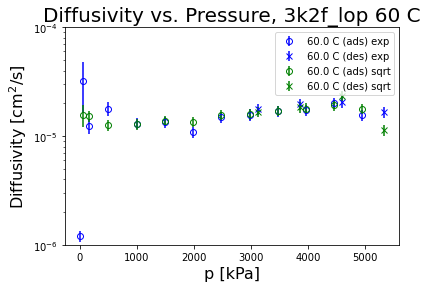

In [38]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, s_D_exp_arr, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', label_tag='exp',
                                 title='Diffusivity vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, ax=ax, color='g', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='sqrt')
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# save figure
save_plots = True
if save_plots:
    plt.savefig(save_folder + 'diff_exp_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The strong agreement between the two methods gives us confidence that their results are fairly reliable.